In [1]:
import pandas as pd
import numpy as np

import arviz as az

import matplotlib.pyplot as plt
import pymc as pm
import bambi as bmb

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
df = pd.read_csv('flats.csv')

In [3]:
df

,Unnamed: 0,price_doc,full_sq,life_sq,num_room,kitch_sq
0,8056,2750000,11,11.0,1.0,12.0
1,8154,7100000,45,27.0,2.0,6.0
2,8287,11700000,77,50.0,3.0,8.0
3,8387,10400000,56,29.0,2.0,10.0
4,8391,6200000,31,21.0,1.0,5.0
...,...,...,...,...,...,...
6037,30462,10544070,47,30.0,1.0,10.0
6038,30463,12000000,56,29.0,2.0,11.0
6039,30467,25000000,86,59.0,4.0,10.0
6040,30469,13500000,64,32.0,2.0,11.0


На первый взгляд признаки можно описать следующим образом:

1. Unnamed: 0 - судя по распределению можно предположить что это идентефикатор жилья
3. price_doc - сумма за жилье
4. full_sq - полная размер жилья
5. life_sq - размер гостевой комнты
6. num_room - колличество комнат
7. kitch_sq - размер кухни

В первой же строке видимо что предполагаемая кухея больше чем жилье, что намекает на возможную ошибочность наших предположений о том чем являются наши признаки, с другой стороны в остальных выведенных строках все значения сходятся. Посмотрим на другое жилье с одной комнатой.

In [4]:
df[df.num_room == 1].sort_values("kitch_sq", ascending=False).head(10)

,Unnamed: 0,price_doc,full_sq,life_sq,num_room,kitch_sq
2806,19095,80777440,184,85.0,1.0,54.0
2702,18792,24000000,66,14.0,1.0,30.0
2581,18344,13000000,165,124.0,1.0,30.0
4872,26336,17409480,78,23.0,1.0,29.0
5112,27118,16321500,78,23.0,1.0,29.0
5204,27429,17924168,78,22.0,1.0,28.0
5914,30002,12216878,96,47.0,1.0,22.0
5885,29904,12303245,96,47.0,1.0,22.0
288,10440,1100000,41,21.0,1.0,21.0
2897,19396,2000000,59,13.0,1.0,21.0


Посмотрим на однокомнатные аппартаменты, то что life_sq это размер гостевой комнаты видится с трудом.

In [5]:
df['price_doc'].corr(df['life_sq'])

0.5246023607665952

Имеется положительная корреляция между ценой и life_sq и достаточно высокая чтобы его оставить.


Пройдемся по строкам и посмотрим на выбросы

In [6]:
for i in df:
    lower_bound = df[i].quantile(q=0.025)
    upper_bound = df[i].quantile(q=0.975)
    print('Столбец',i)
    print(len(df[(df[i] < lower_bound) | (df[i] > upper_bound)]))

Столбец Unnamed: 0
304
Столбец price_doc
189
Столбец full_sq
255
Столбец life_sq
298
Столбец num_room
28
Столбец kitch_sq
170


Не смотрим на Unnamed: 0 и price_doc, так как один из них выбрасывается при обучении а второй это то что мы будем пытаться предсказать.

In [7]:
lower_bound = df['life_sq'].quantile(q=0.025)
upper_bound = df['life_sq'].quantile(q=0.975)
df[(df['life_sq'] < lower_bound) | (df['life_sq'] > upper_bound)].sort_values("life_sq", ascending=False).head(10)

,Unnamed: 0,price_doc,full_sq,life_sq,num_room,kitch_sq
3898,22785,4725142,637,637.0,2.0,10.0
72,9256,13750000,77,458.0,3.0,10.0
5315,27793,3134129,407,407.0,1.0,10.0
1548,14709,7115197,167,167.0,3.0,1.0
492,11116,20751018,165,165.0,4.0,0.0
5815,29656,70000000,211,162.0,6.0,19.0
3632,21921,7267500,160,160.0,3.0,0.0
4571,25304,36860612,160,155.0,4.0,20.0
4531,25149,41303380,153,153.0,4.0,1.0
4955,26655,44425664,150,146.0,4.0,1.0


life_sq крайне странный параметр, и так как мы точно не знаем что же он значит тяжело оценить стоит нам удалять определенные строки или нет. Иногда он совпадает с life_sq, иногда больше и не ясно до конца ошибка ли это ввода или нет. У нас есть некоторое колличество выбросов но большая их часть объясняется гипер-дорогим и гипер-просторным жильем которое есть в датасете, такое жилье удалять не хочется так как если мы удалим его предсказания похожего жилья будут посредственными. Посмотрим колличество строк в котором life_sq больше full_sq и продолжим.

In [8]:
df[df['life_sq']>df['full_sq']]

,Unnamed: 0,price_doc,full_sq,life_sq,num_room,kitch_sq
72,9256,13750000,77,458.0,3.0,10.0
3773,22412,14923206,1,47.0,1.0,1.0
5726,29302,11000000,56,57.0,3.0,5.0


In [9]:
df[df['kitch_sq']>df['full_sq']]

,Unnamed: 0,price_doc,full_sq,life_sq,num_room,kitch_sq
0,8056,2750000,11,11.0,1.0,12.0


Итак "странных" строк как оказалось всего 4, просто удалим их от греха подальше, с ними же удалим кухни размером со все жилье.

In [10]:
df = df[df['kitch_sq']<df['full_sq']]
df = df[df['life_sq']<=df['full_sq']]
df

,Unnamed: 0,price_doc,full_sq,life_sq,num_room,kitch_sq
1,8154,7100000,45,27.0,2.0,6.0
2,8287,11700000,77,50.0,3.0,8.0
3,8387,10400000,56,29.0,2.0,10.0
4,8391,6200000,31,21.0,1.0,5.0
5,8410,5950000,43,27.0,2.0,5.0
...,...,...,...,...,...,...
6037,30462,10544070,47,30.0,1.0,10.0
6038,30463,12000000,56,29.0,2.0,11.0
6039,30467,25000000,86,59.0,4.0,10.0
6040,30469,13500000,64,32.0,2.0,11.0


In [11]:
print(df['price_doc'].corr(df['Unnamed: 0']))
df=df.drop('Unnamed: 0',axis='columns')

0.08502663003171175


In [12]:
df.isna().sum().sum()

0

In [13]:
model = bmb.Model('price_doc ~ full_sq + life_sq + num_room + kitch_sq', df, dropna=True)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [price_doc_sigma, Intercept, full_sq, life_sq, num_room, kitch_sq]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


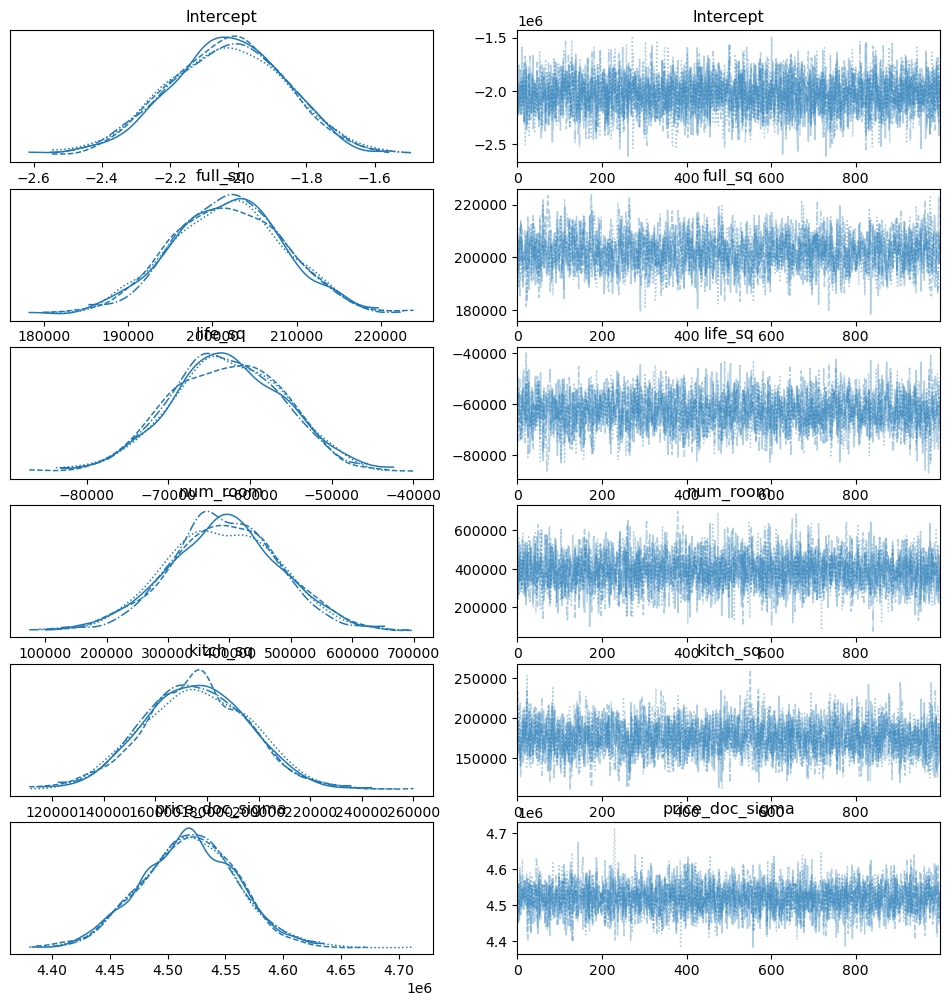

In [15]:
results = model.fit()
az.plot_trace(results);

In [19]:
az.summary(results)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-2032609.128,175406.642,-2351813.866,-1700465.367,2768.131,1957.506,4013.0,3321.0,1.0
full_sq,201912.545,6722.773,189360.901,214505.697,154.834,109.705,1886.0,2180.0,1.0
life_sq,-62855.461,7003.911,-75578.329,-49758.489,146.742,104.236,2279.0,2348.0,1.0
num_room,391299.536,90317.851,220188.938,560243.739,1524.158,1116.598,3521.0,3003.0,1.0
kitch_sq,175793.235,20467.172,138225.908,213903.018,392.302,277.440,2725.0,2780.0,1.0
price_doc_sigma,4518791.444,41183.272,4442309.819,4595255.538,684.964,484.471,3649.0,2765.0,1.0


In [27]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(df[['full_sq','life_sq','num_room','kitch_sq']], df['price_doc'])

C:\Users\miron\anaconda3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\miron\anaconda3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\miron\anaconda3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\miron\anaconda3\envs\pymc_env\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version

LinearRegression()

In [28]:
lr.intercept_

-2037405.5630260743

In [32]:
pd.DataFrame(lr.coef_, index=['full_sq','life_sq','num_room','kitch_sq'])

,0
full_sq,201819.769056
life_sq,-62692.305878
num_room,392096.422270
kitch_sq,176158.342946


#### Коэффициенты близки друг к другу по значениям
